In [1]:
import sys
sys.path.insert(0,'..')

from src.models import *
from src.loss_functions import *
from src.noise import *
from src.metrics import *
from src.plotting import *
from src.generate_data import *
from src.real_data import *

import sklearn
from sklearn.metrics import roc_curve, auc
import pandas as pd

from scipy.stats import bernoulli, spearmanr

from operator import xor

import os




In [2]:
def plot_metric(df, highlight = "Instance", ax=None):
    
    metric = df["Metric"].unique()[0]

    loss_functions = len(df["Loss Function"].unique())
    
    # Create the plot
    ax = ax or plt.gca()

    if loss_functions != 1:
        sns.boxplot(x='Noise Level (%)', y='Rate (%)', hue='Loss Function', data=df, ax=ax, palette="Set2", showfliers=False, boxprops=dict(alpha=0.8))
        sns.stripplot(x="Noise Level (%)", y="Rate (%)", hue="Loss Function", data=df, jitter=True, dodge=True,
                           marker = "x", size=0.5, linewidth=5, ax=ax, alpha = 0.8, palette="Set2", legend = False)
    else:
        sns.boxplot(x='Noise Level (%)', y='Rate (%)', data=df, ax=ax, showfliers=False, boxprops=dict(alpha=0.8))
        sns.stripplot(x="Noise Level (%)", y="Rate (%)", data=df, jitter=True, dodge=True,
                           marker = "x", color = "black", size=0.5, linewidth=5, ax=ax, alpha = 0.8, legend = False)
    # Scatter plot with or without color

    bright_colors = ['#E63946', '#F4A261', '#2A9D8F', '#264653', '#E9C46A']


    if "disagreement" in metric or "regret" in metric:
        if highlight == "Instance":

            np.random.seed(2024)
            color_indices = np.random.choice(df.Index.unique(), size=5, replace=False)

            for i, item in enumerate(color_indices):
                data_subset = df[df["Index"] == item]

                sns.stripplot(x="Noise Level (%)", y="Rate (%)", hue="Loss Function", data=data_subset, jitter=True, dodge=True,
                              marker='o', facecolors='none', size=10, alpha = 0.8, linewidth=10, edgecolor=bright_colors[i], ax=ax, legend = False)
        elif highlight in ["Class", "age", "sex", "hiv"]:
            unique_vals = df[highlight].unique()
            for i, u in enumerate(unique_vals):
                sns.stripplot(x="Noise Level (%)", y="Rate (%)", hue="Loss Function", data=df[df[highlight]==u], jitter=True, dodge = True,
                                   size=6, alpha = 0.5, palette = bright_colors[i:i+1], ax=ax, legend=False)

        
    # Add legend and adjust plot details
    handles, labels = ax.get_legend_handles_labels()

    # Set plot title and labels if ax is None
    if ax is None:
        ax.set_xlabel('Noise Level (%)')
        ax.set_ylabel(f'{metric} Rate (%)')
        plt.show()

# Note: Ensure the 'metrics' object and the 'metric' variable are properly defined before calling this function.



def load_metrics(model_type, noise_type, uncertainty_type, metric, group = "age",  dataset = 'cshock_eicu', fixed_class = None, fixed_noise = None, epsilon = 0.1, misspecify = "correct"):
    
    parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    
    #metrics_dir = os.path.join(parent_dir, "results", "raw", "metrics", dataset, model_type, noise_type)
    parent_dir = "/scratch/hdd001/home/snagaraj/"
    metrics_dir = os.path.join(parent_dir, "results", "metrics", dataset, model_type, noise_type, misspecify)

    # Prepare the data
    
    if uncertainty_type == "forward":
        loss_functions = ["Ours", "BCE", "forward", "backward"]
    else:
        loss_functions = ["Ours"]

    
    if ("disagreement" in metric) or ("regret" in metric):
        
        _, _, y_train, y_test, group_train, group_test = load_dataset_splits(dataset, group = group)
        
        group_vec = group_test if "test" in metric else group_train
        label_vec = y_test if "test" in metric else y_test
        
        
    rows = []
    
    for loss_function in loss_functions:
        for file_name in os.listdir(metrics_dir):
            if file_name.endswith('.pkl') and uncertainty_type in file_name:
                path = os.path.join(metrics_dir, file_name)

                parts = file_name.split('_')
                
                if noise_type == "class_conditional":
                    f_class = int(parts[2])
                    f_noise = float(parts[3])
                    
                    if (f_class != fixed_class) or (f_noise != fixed_noise):
                        continue
                    
                noise = float(parts[1]) # Assumes file name format: {uncertainty}_{noise}_{epsilon}_metrics.pkl
                eps = float(parts[-2])

                if eps != epsilon:
                    continue
                
                with open(path, 'rb') as file:
                    # The noise level and uncertainty type are inferred from the file name
                    
                    metrics = pkl.load(file)

                for m in metrics.data[loss_function].keys():
                    
                    if m == metric:
                        for i, value in enumerate(metrics.data[loss_function][metric]):
                            if ("disagreement" in metric) or ("regret" in metric):
                                rows.append({
                                    'Metric': m,
                                    'Noise Level (%)': round(noise * 100),  # Assume noise is a fraction
                                    'Rate (%)': value,
                                    'Loss Function': loss_function,
                                    'Index': i,
                                    "Class": label_vec[i],
                                    f"{group}": group_vec[i]})
                
                            else:
                                rows.append({
                                    'Metric': m,
                                    'Noise Level (%)': round(noise * 100),  # Assume noise is a fraction
                                    'Rate (%)': value,
                                    'Loss Function': loss_function,
                                    'Index': i })
                

    # Scan through all files in the directory for the model_type
    
                    
    return pd.DataFrame(rows)



In [3]:
model_type = "LR"
noise_type = "class_conditional"

uncertainty_type = "forward"
metric = "clean_test_acc"
dataset = "cshock_mimic"
fixed_class = 0
fixed_noise = 0

metrics_df = load_metrics(model_type, noise_type, uncertainty_type, metric=metric, dataset=dataset, fixed_class=fixed_class, fixed_noise=fixed_noise)

In [4]:
metrics_df

Metric  Noise Level (%)   Rate (%) Loss Function  Index
0     clean_test_acc                0  80.989839          Ours      0
1     clean_test_acc                0  80.989839          Ours      1
2     clean_test_acc                0  80.989839          Ours      2
3     clean_test_acc                0  80.989839          Ours      3
4     clean_test_acc                0  80.989839          Ours      4
...              ...              ...        ...           ...    ...
2395  clean_test_acc                1  80.957063      backward     95
2396  clean_test_acc                1  80.924287      backward     96
2397  clean_test_acc                1  80.924287      backward     97
2398  clean_test_acc                1  81.120944      backward     98
2399  clean_test_acc                1  80.825959      backward     99

[2400 rows x 5 columns]

# Experiment 1 - Noise Robustness / Ambiguity by Model Class

Failed to load or plot data for cshock_eicu, class_independent , LR, clean_test_acc. Error: 'Loss Function'
Failed to load or plot data for cshock_eicu, class_independent , LR, regret_test. Error: index 0 is out of bounds for axis 0 with size 0
Failed to load or plot data for cshock_eicu, class_independent , LR, disagreement_test. Error: index 0 is out of bounds for axis 0 with size 0
Failed to load or plot data for cshock_eicu, class_independent , NN, clean_test_acc. Error: 'Loss Function'
Failed to load or plot data for cshock_eicu, class_independent , NN, regret_test. Error: index 0 is out of bounds for axis 0 with size 0
Failed to load or plot data for cshock_eicu, class_independent , NN, disagreement_test. Error: index 0 is out of bounds for axis 0 with size 0
Failed to load or plot data for cshock_mimic, class_independent , LR, clean_test_acc. Error: 'Loss Function'
Failed to load or plot data for cshock_mimic, class_independent , LR, regret_test. Error: index 0 is out of bounds 

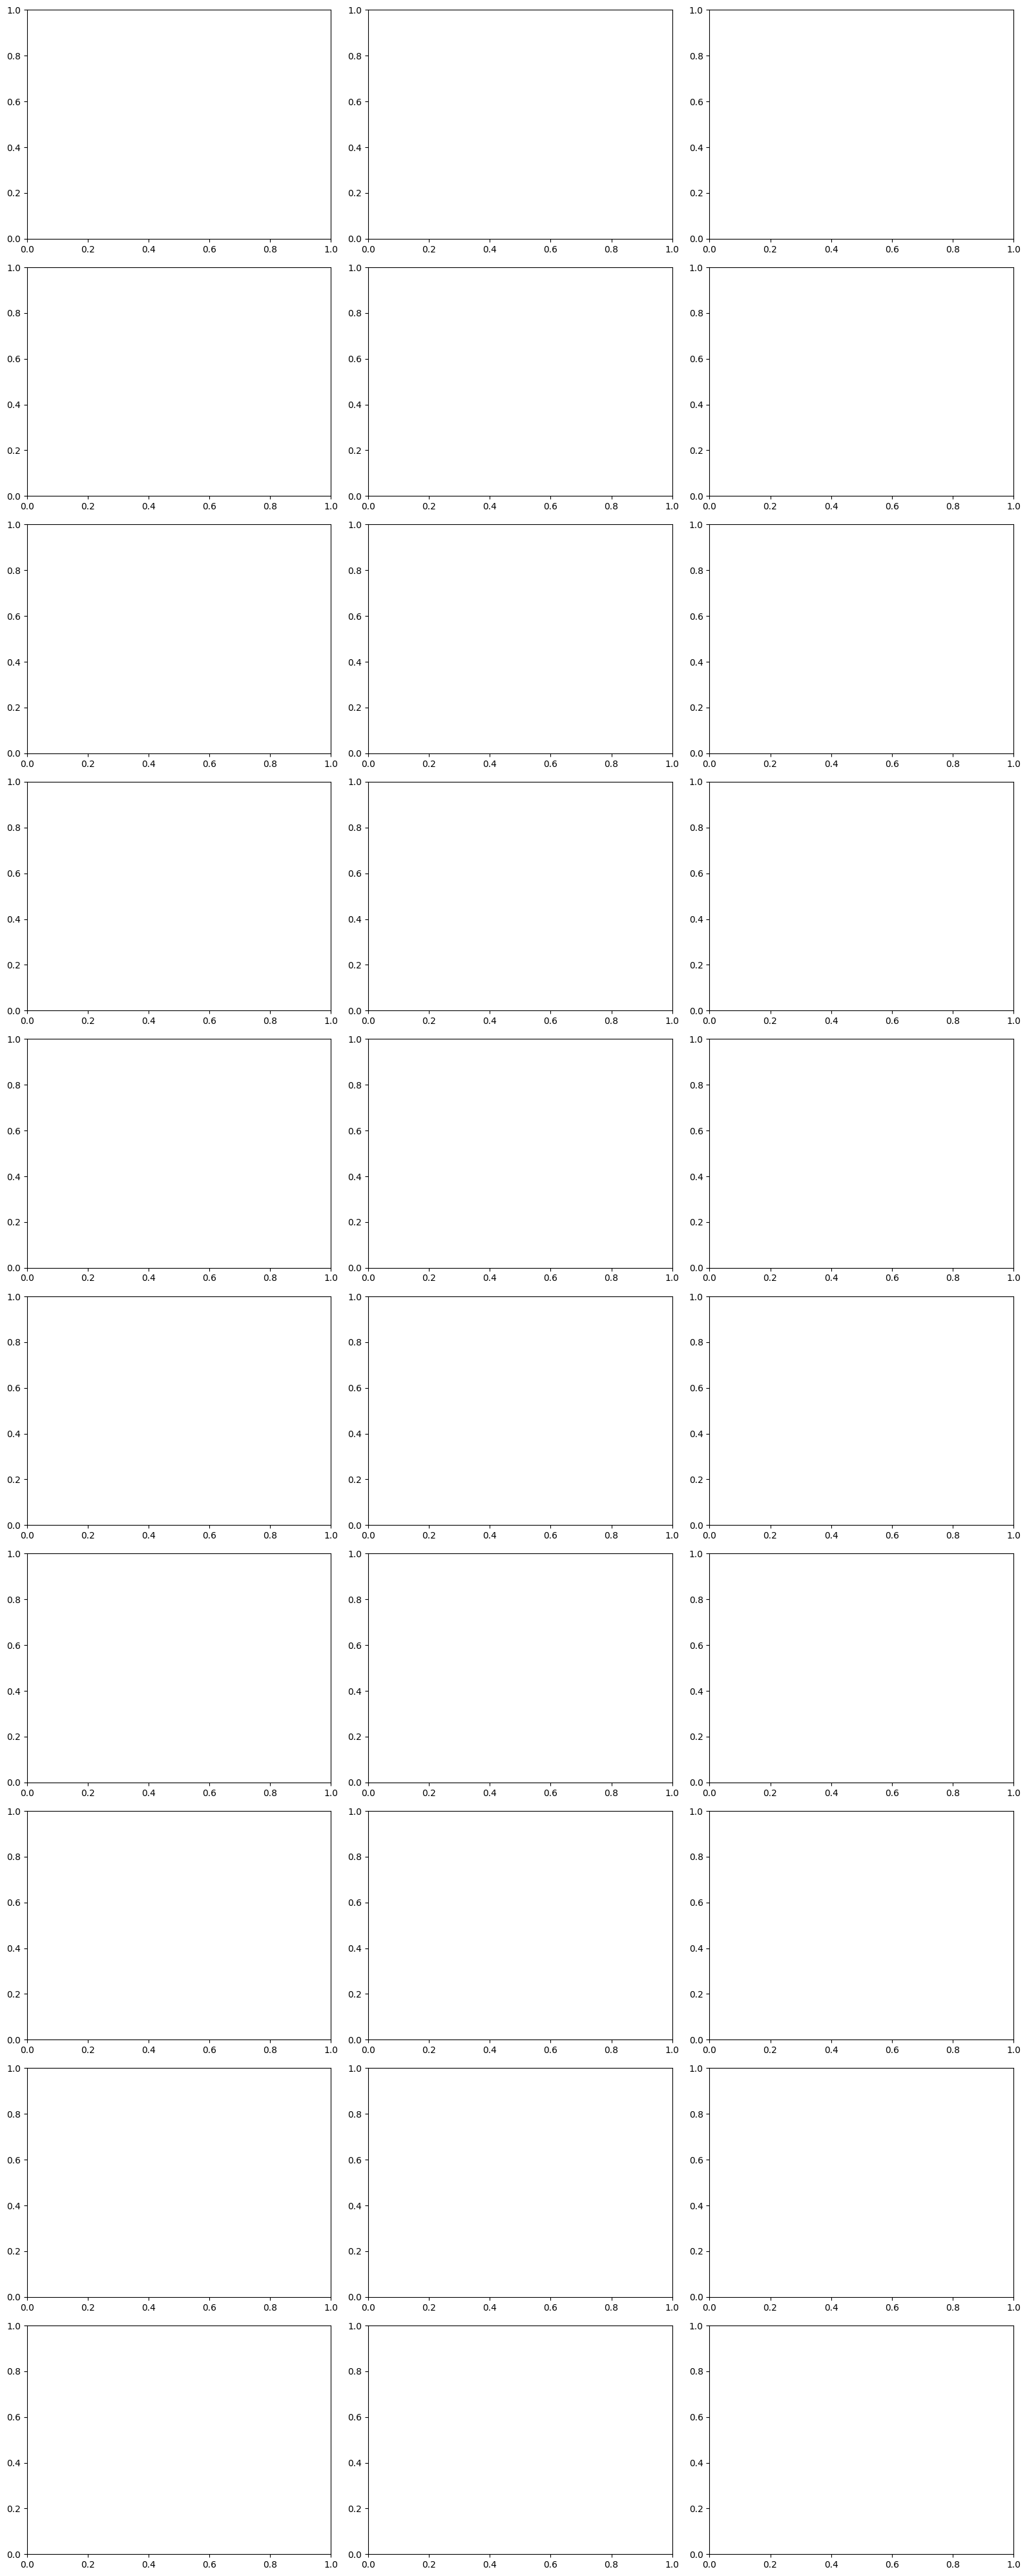

Failed to load or plot data for cshock_eicu, class_conditional , LR, clean_test_acc. Error: 'Loss Function'
Failed to load or plot data for cshock_eicu, class_conditional , LR, regret_test. Error: index 0 is out of bounds for axis 0 with size 0
Failed to load or plot data for cshock_eicu, class_conditional , LR, disagreement_test. Error: index 0 is out of bounds for axis 0 with size 0
Failed to load or plot data for cshock_eicu, class_conditional , NN, clean_test_acc. Error: 'Loss Function'
Failed to load or plot data for cshock_eicu, class_conditional , NN, regret_test. Error: index 0 is out of bounds for axis 0 with size 0
Failed to load or plot data for cshock_eicu, class_conditional , NN, disagreement_test. Error: index 0 is out of bounds for axis 0 with size 0
Failed to load or plot data for cshock_mimic, class_conditional , LR, clean_test_acc. Error: 'Loss Function'
Failed to load or plot data for cshock_mimic, class_conditional , LR, regret_test. Error: index 0 is out of bounds 

<Figure size 640x480 with 0 Axes>

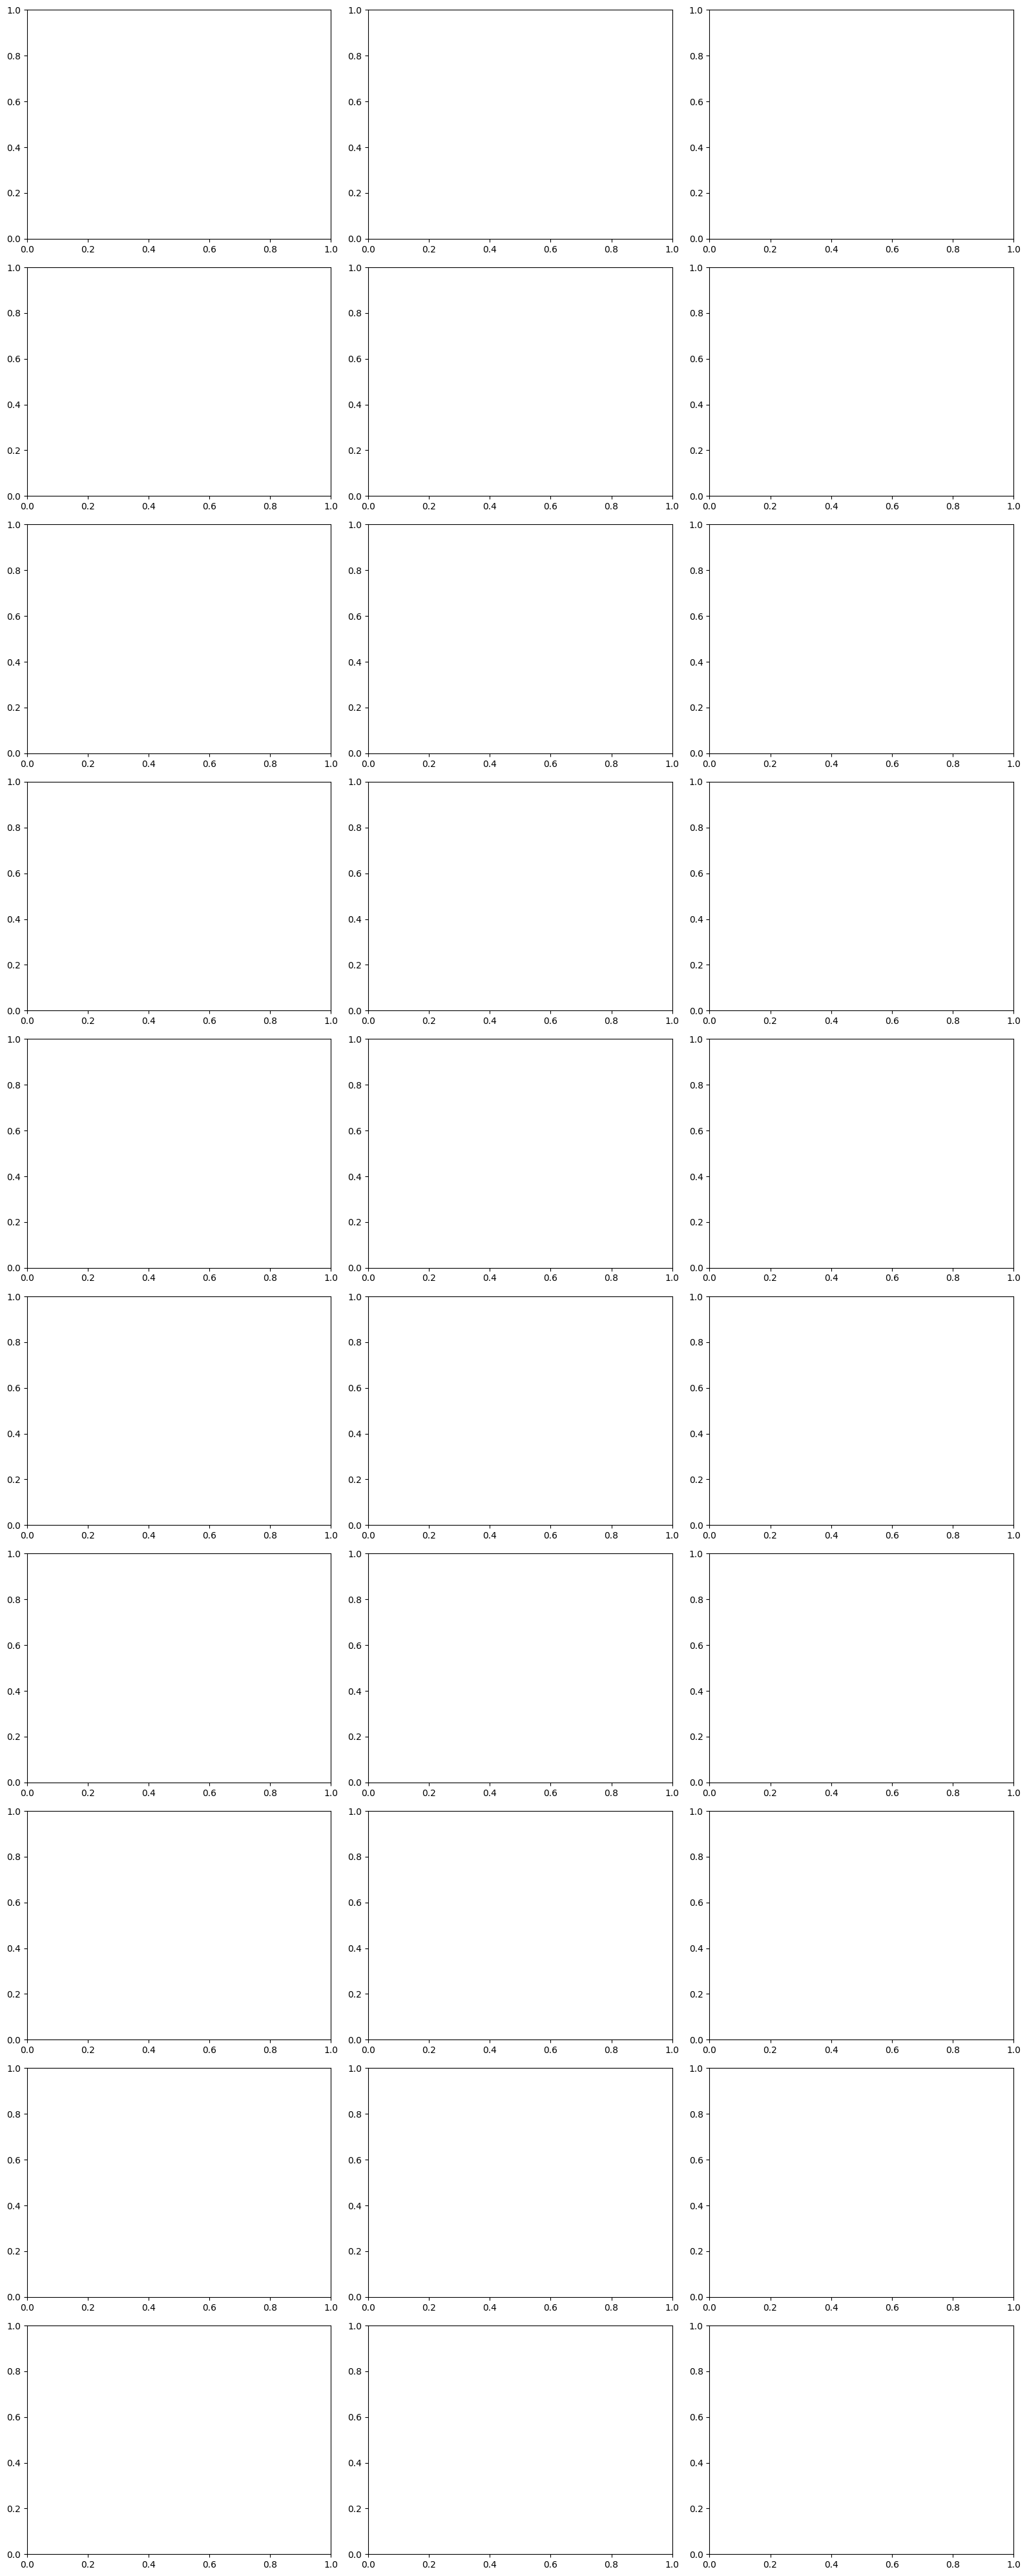

<Figure size 640x480 with 0 Axes>

In [5]:
# Define model types and datasets
model_types = ["LR", "NN"]
datasets = ["cshock_eicu", "cshock_mimic", "saps", "support", "lungcancer"]
metrics = ['clean_test_acc', 'regret_test', 'disagreement_test']

uncertainty_type = "backward"
noise_type = "class_independent"
epsilon = 0.1
fixed_class = 0
fixed_noise = 0

for noise_type in ["class_independent", "class_conditional"]:

    # Create a figure with subplots
    # Number of rows is number of datasets times number of model types
    # Number of columns is the number of metrics
    fig, axs = plt.subplots(len(datasets) * len(model_types), len(metrics), figsize=(16, 4 * len(datasets) * len(model_types)))

    # Flatten the axes array for easier indexing
    axs = axs.ravel()

    # Initialize a counter for the axes
    ax_index = 0

    # Iterate over datasets and model types
    for dataset in datasets:
        for model_type in model_types:
            for metric in metrics:
                try:
                    # Load metrics data
                    metrics_df = load_metrics(model_type, noise_type, uncertainty_type, metric=metric, dataset=dataset, fixed_class=fixed_class, fixed_noise=fixed_noise, epsilon = epsilon)

                    # Plot the metric on the corresponding subplot
                    ax = axs[ax_index]
                    plot_metric(metrics_df[metrics_df["Loss Function"]!= "Ours"], highlight="Instance", ax=ax)
                    ax.set_title(f"{dataset}_{model_type}_{metric}")

                    # Increment the axis index for the next metric
                    ax_index += 1

                except Exception as e:
                    print(f"Failed to load or plot data for {dataset}, {noise_type} , {model_type}, {metric}. Error: {str(e)}")
                    # Increment the axis index even on failure to keep grid alignment
                    ax_index += 1

    # Adjust layout
    plt.tight_layout()

    # Show the figure
    plt.show()

    # Optionally, save the figure to a file
    plt.savefig(f"{noise_type}_experiment1.pdf")

# Experiment 2

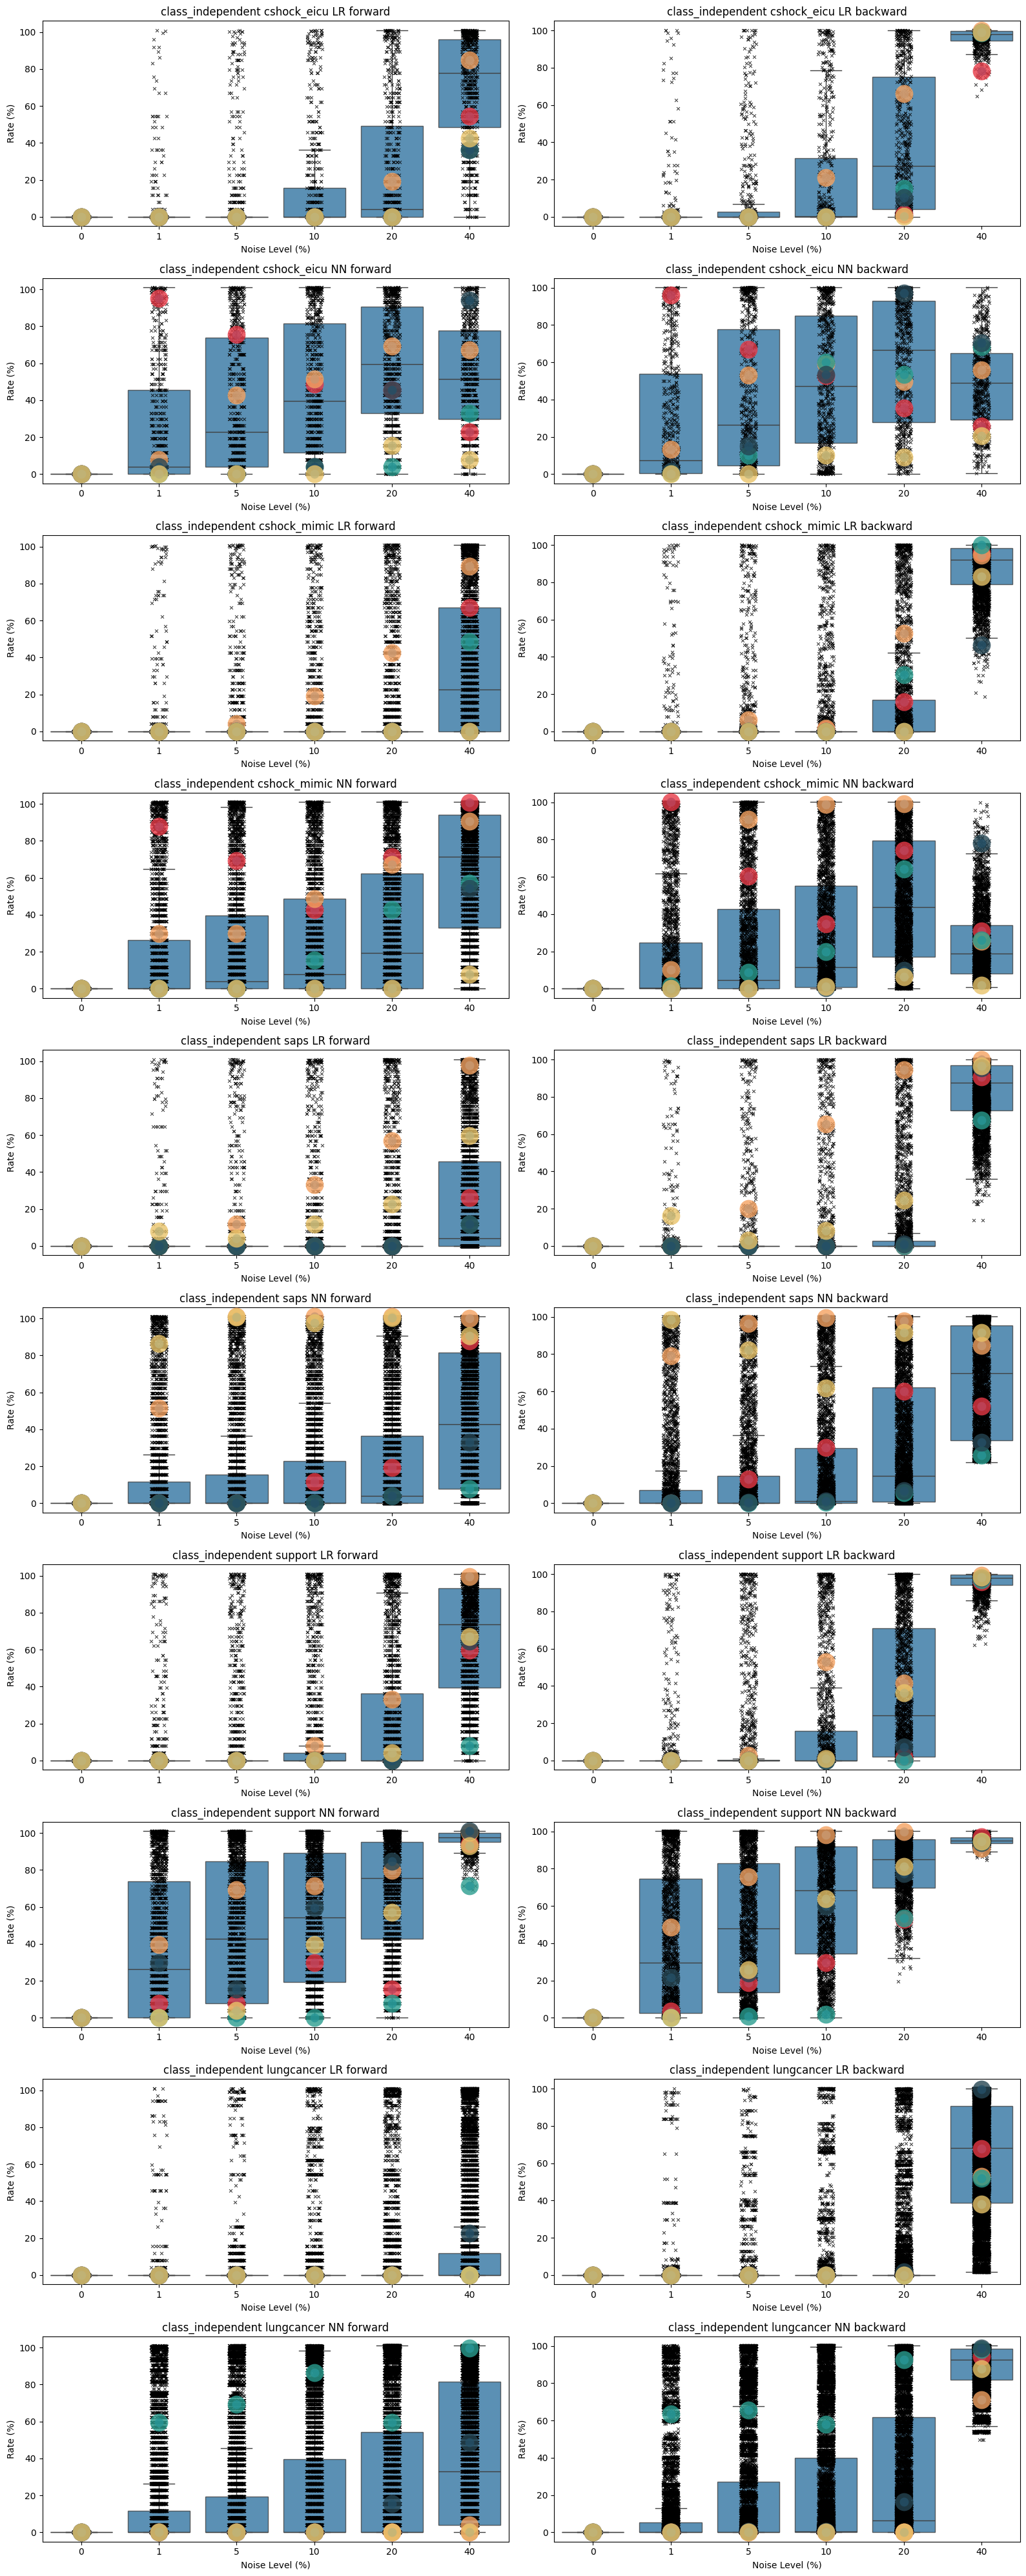

<Figure size 640x480 with 0 Axes>

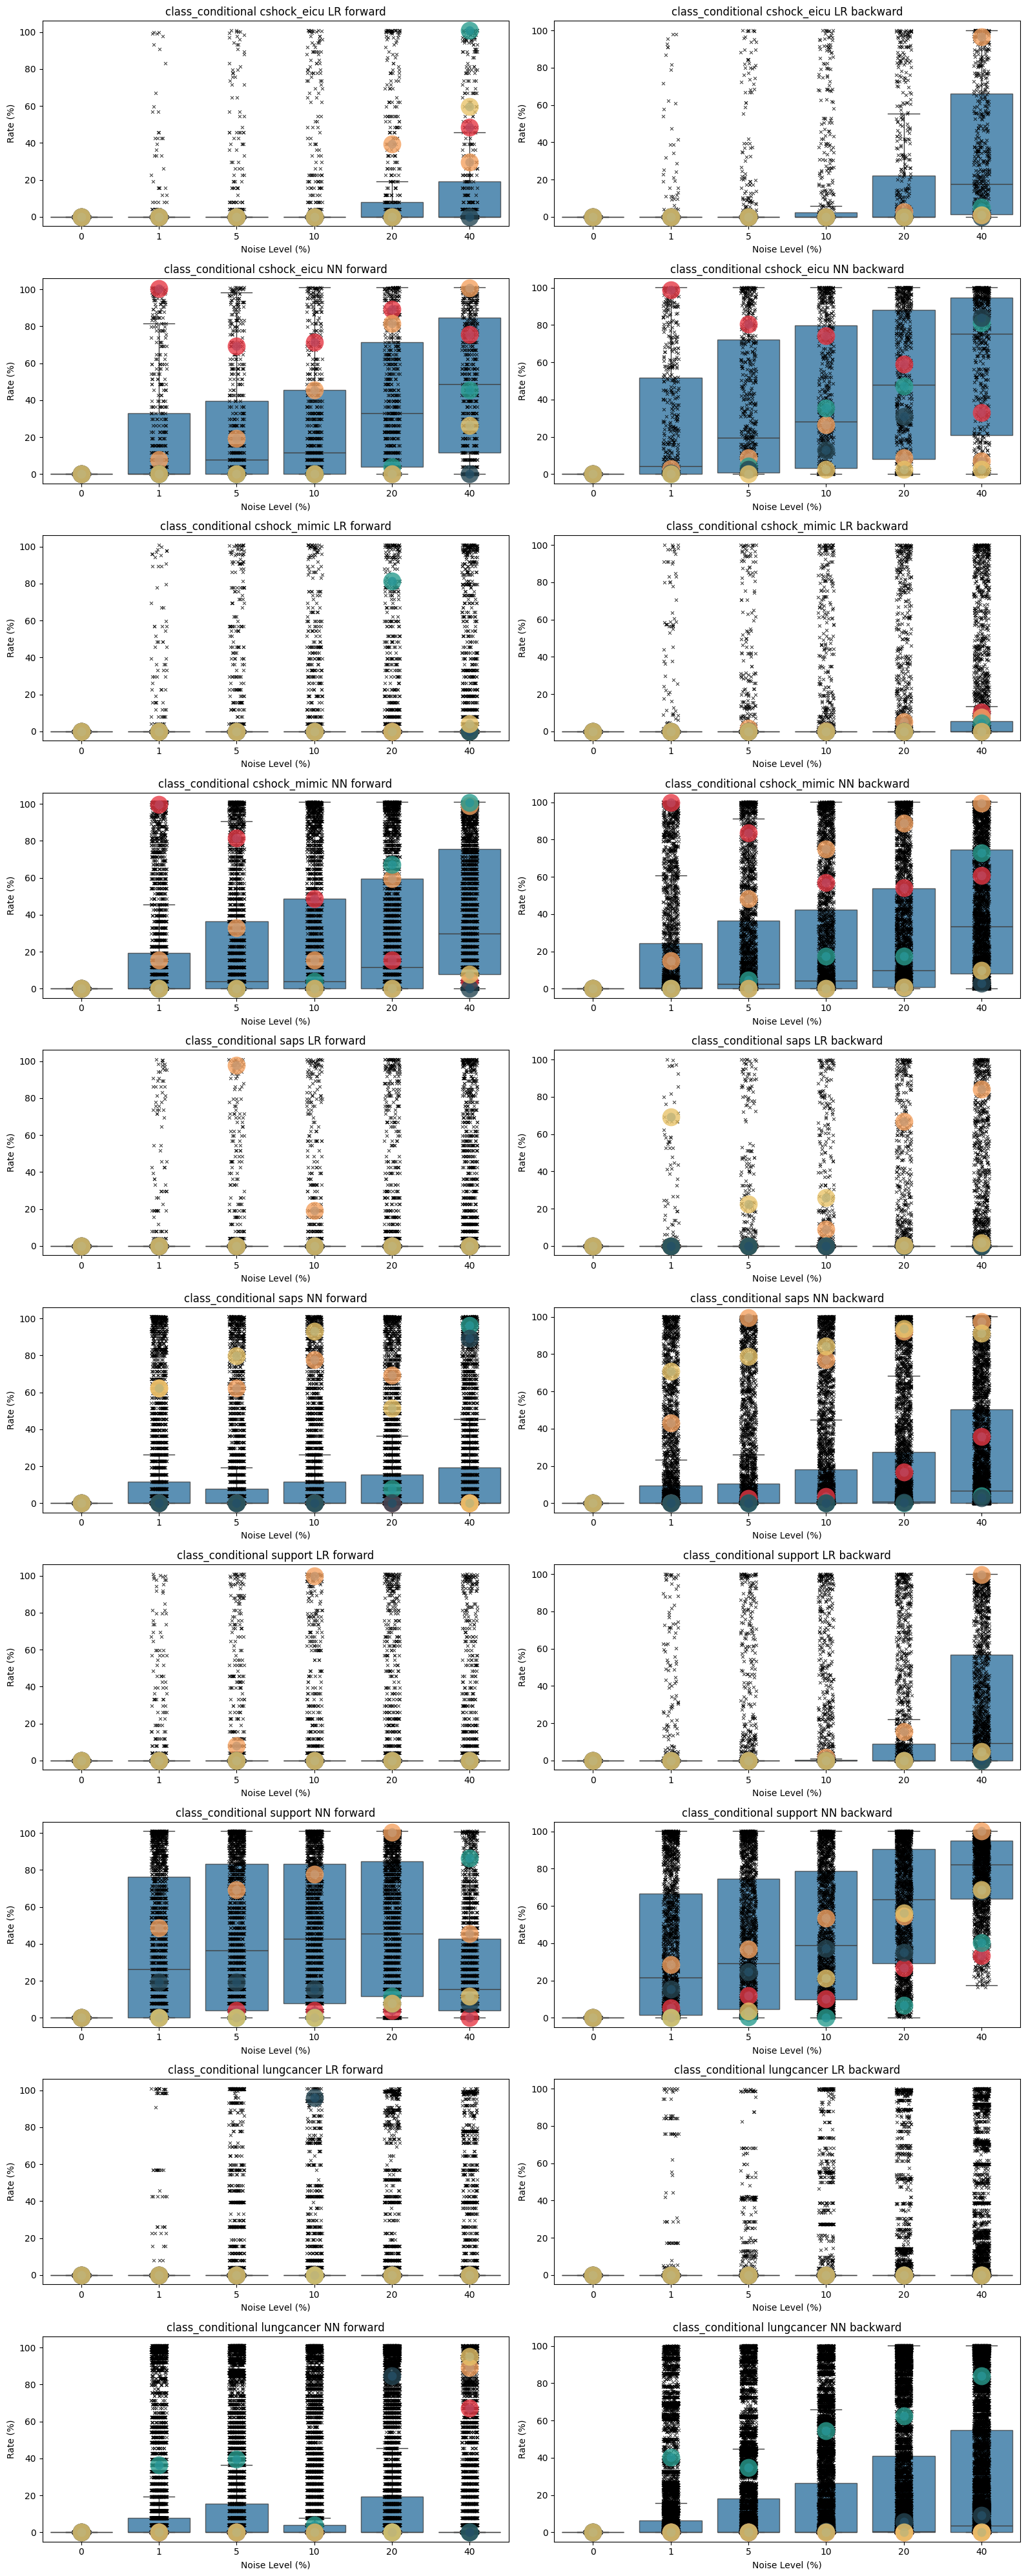

<Figure size 640x480 with 0 Axes>

In [6]:
# Define model types and datasets
model_types = ["LR", "NN"]
datasets = ["cshock_eicu", "cshock_mimic", "saps", "support", "lungcancer"]
uncertainty_types = ['forward', 'backward']
metric = "disagreement_test"



# Iterate over datasets and model types
for noise_type in ["class_independent", "class_conditional"]:
    # Create a figure with subplots
    # Number of rows is number of datasets times number of model types
    # Number of columns is the number of metrics
    fig, axs = plt.subplots(len(datasets) * len(model_types), len(uncertainty_types), figsize=(16, 4 * len(datasets) * len(model_types)))

    # Flatten the axes array for easier indexing
    axs = axs.ravel()

    # Initialize a counter for the axes
    ax_index = 0

    for dataset in datasets:
        for model_type in model_types:
            for uncertainty_type in uncertainty_types:
                try:
                    # Load metrics data
                    metrics_df = load_metrics(model_type, noise_type, uncertainty_type, metric=metric, dataset=dataset, fixed_class=fixed_class, fixed_noise=fixed_noise)

                    metrics_df = metrics_df[metrics_df["Loss Function"]=="Ours"]
                    # Plot the metric on the corresponding subplot
                    ax = axs[ax_index]
                    plot_metric(metrics_df, highlight="Instance", ax=ax)
                    ax.set_title(f"{noise_type} {dataset} {model_type} {uncertainty_type}")

                    # Increment the axis index for the next metric
                    ax_index += 1

                except Exception as e:
                    print(f"Failed to load or plot data for {dataset}, {noise_type}, {model_type}, {metric}. Error: {str(e)}")
                    # Increment the axis index even on failure to keep grid alignment
                    ax_index += 1

    # Adjust layout
    plt.tight_layout()

    # Show the figure
    plt.show()

    # Optionally, save the figure to a file
    plt.savefig(f"{noise_type}_experiment2.pdf")

In [7]:
def compute_tpr_fpr(array1, array2, threshold, fixed_threshold=20):
    
    array1 = np.copy(array1)
    array2 = np.copy(array2)
    def indices_above_threshold(array, thresh):

        array = np.clip(array, 0, 100)
        
        return ((array > thresh)).astype(int)

    # Get indices above threshold for both arrays
    indices1 = (indices_above_threshold(array1, fixed_threshold))  # True condition indices
    indices2 = (indices_above_threshold(array2, threshold))  # Predicted condition indices
    
    # Calculate True Positives (TP)
    tp = np.sum(indices1 & indices2)

    # Calculate False Negatives (FN)
    fn = np.sum(indices1 & (~indices2))
    
    # Calculate False Positives (FP)
    fp = np.sum((~indices1) & indices2)
    
    #print(tp, fn, fp)
    

        # True Positive Rate (TPR) calculation
    tpr = tp / np.sum(indices1) if np.sum(indices1) > 0 else 0
    
    fpr = fp / np.sum((1-indices1)) if np.sum((1-indices1)) > 0 else 0
    
    return tpr,fpr


In [8]:
array1 = np.array([1.0, 0.0, 1.0, 1.0])

array2 = np.array([1.0, 1.0, 0.0, 1.0])

print(compute_tpr_fpr(array1, array2, 0.5, fixed_threshold=0.5))

(0.6666666666666666, 1.0)


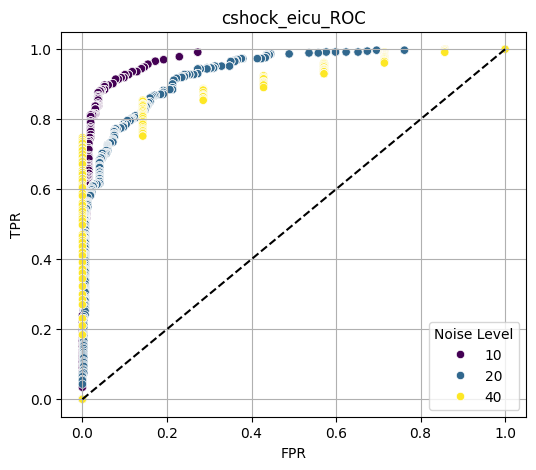

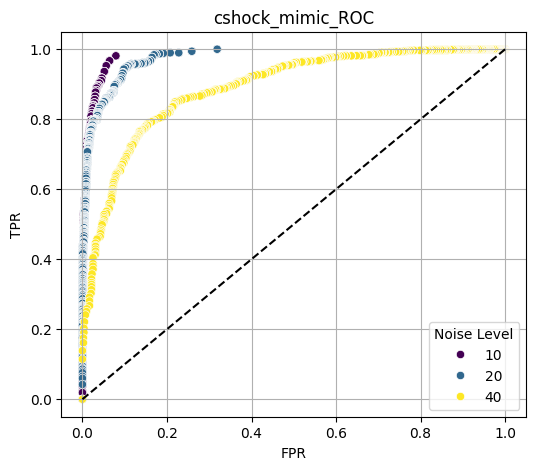

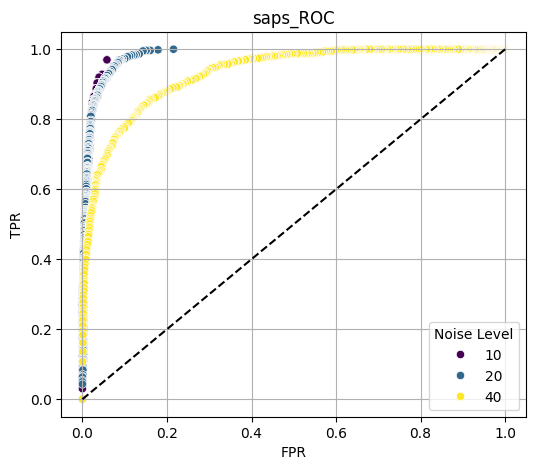

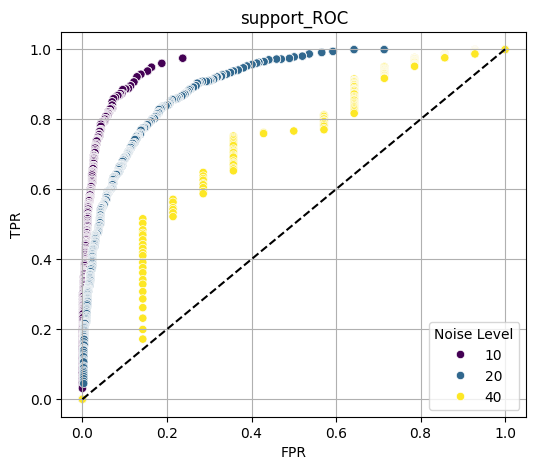

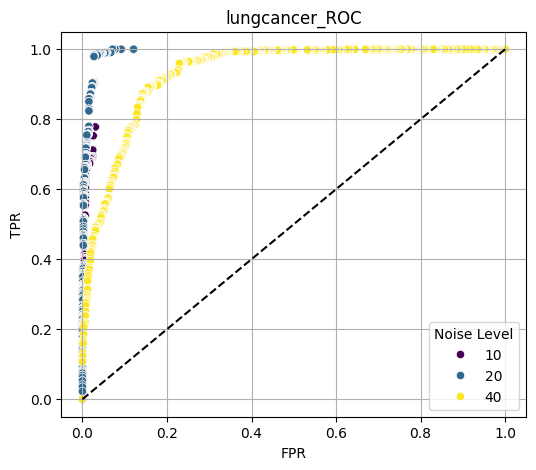

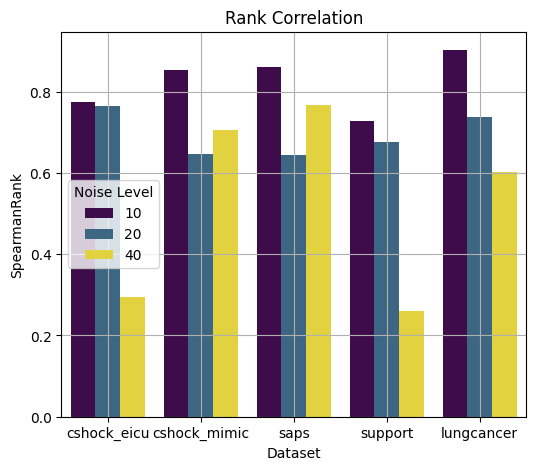

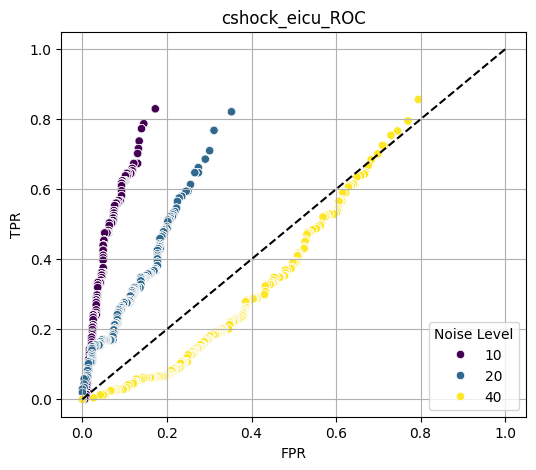

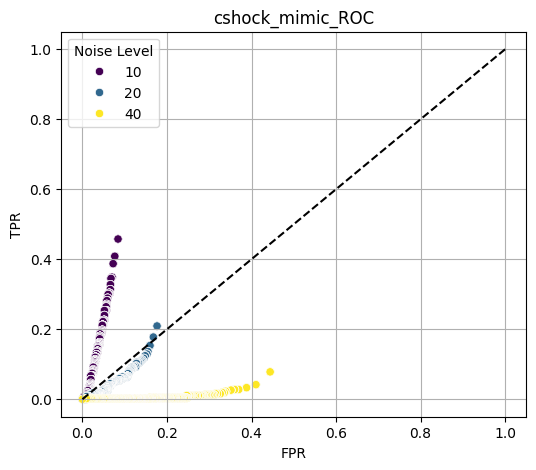

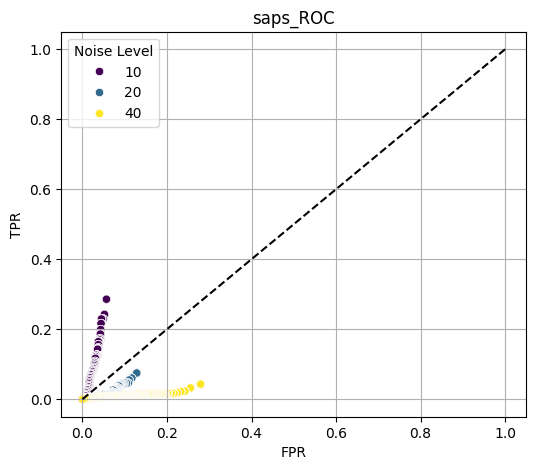

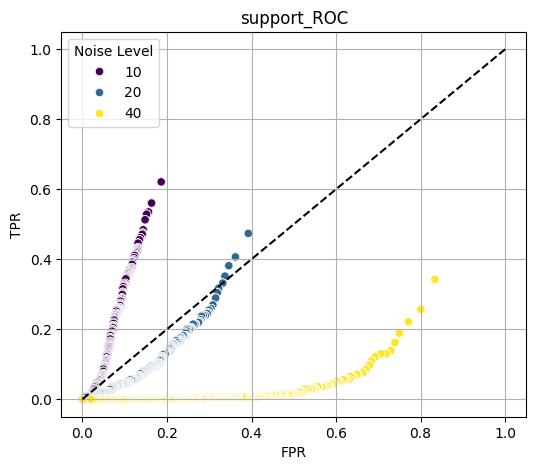

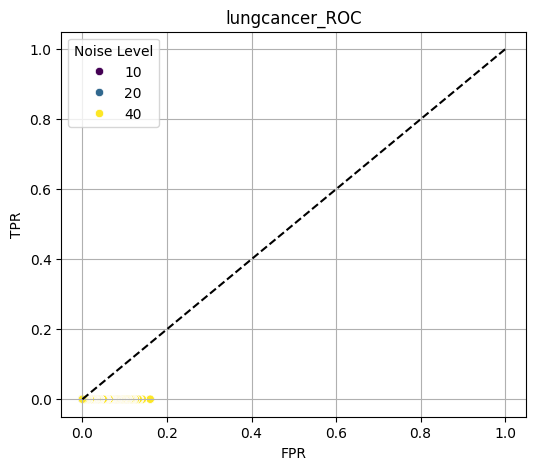

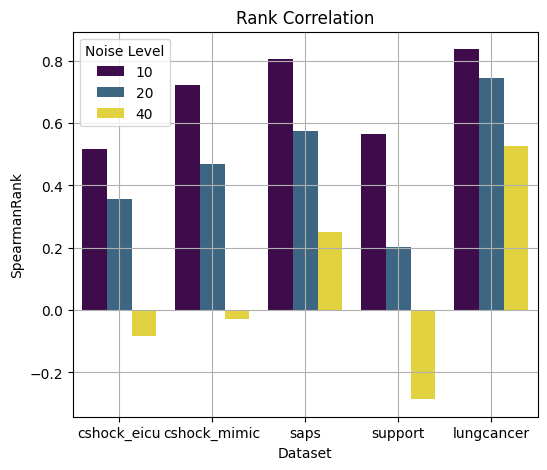

In [9]:

# Define the parameters
metric = "disagreement_test"
model_type = "LR"
noise_type = "class_independent"
fixed_class = 0
fixed_noise = 0

fixed_threshold = 0

overlap_metric = "dice"
loss = "Ours"

datasets = ["cshock_eicu", "cshock_mimic", "saps", "support", "lungcancer"]



for noise_type in ["class_independent", "class_conditional"]:
    thresholds = []  # Generates 20 evenly spaced values from 0 to 100
    overlaps = []
    tprs = []
    fprs = []
    noise_levels = []
    ds = []

    for dataset in datasets:
        # Initialize lists to store the results and noise levels for DataFrame


        forward_df = load_metrics(model_type, noise_type, "forward", metric="disagreement_test", dataset = dataset, fixed_class=fixed_class, fixed_noise = fixed_noise)
        backward_df = load_metrics(model_type, noise_type, "backward", metric="disagreement_test", dataset = dataset, fixed_class=fixed_class, fixed_noise = fixed_noise)


        for noise_level in [10, 20, 40]:
            forward_sub_df = forward_df[(forward_df["Loss Function"]==loss) & (forward_df["Noise Level (%)"]==noise_level)]
            backward_sub_df = backward_df[(backward_df["Loss Function"]==loss) & (backward_df["Noise Level (%)"]==noise_level)]

            forward_values = forward_sub_df["Rate (%)"].values
            backward_values = backward_sub_df["Rate (%)"].values

                            # Getting rank orderings: argsort gives index positions of sorted order, argsort of that gives ranks
            forward_ranks = np.argsort(np.argsort(forward_values))
            backward_ranks = np.argsort(np.argsort(backward_values))

            if len(forward_values) != 0 and len(backward_values) != 0:

                # Loop over each threshold value
                for t in np.linspace(0, 100, 1000):

                    # Calculate Spearman rank correlation
                    result, _ = spearmanr(forward_ranks, backward_ranks)

                    #overlap = compute_overlap(forward_values, backward_values, threshold, overlap_metric=overlap_metric)
                    overlaps.append(result)

                    tpr, fpr = compute_tpr_fpr(forward_values, backward_values, t, fixed_threshold = fixed_threshold)
                    tprs.append(tpr)
                    fprs.append(fpr)
                    ds.append(dataset)

                    noise_levels.append(noise_level)  # Store the corresponding noise level for each result
                    thresholds.append(t)

    # Create a DataFrame
    data = pd.DataFrame({
        "Dataset": ds,
        'Threshold': thresholds,
        'Overlap': overlaps,
        'Noise Level': noise_levels,
        "TPR": tprs,
        "FPR": fprs
    })

    for dataset in datasets:
        # Plotting using seaborn with hue for noise level
        plt.figure(figsize=(6, 5))
        sns.scatterplot(data=data[data["Dataset"]==dataset], x='FPR', y='TPR', palette='viridis', hue='Noise Level', marker='o')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('FPR')
        plt.ylabel("TPR")
        plt.grid(True)
        plt.title(f'{dataset}_ROC')
        plt.grid(True)
        plt.show()

    plt.figure(figsize=(6, 5))
    sns.barplot(data=data, x='Dataset', y='Overlap', hue = "Noise Level", palette='viridis')
    plt.xlabel('Dataset')
    plt.ylabel("SpearmanRank")
    plt.grid(True)
    plt.title(f'Rank Correlation')

    plt.show()



In [10]:
data

Dataset  Threshold   Overlap  Noise Level       TPR       FPR
0      cshock_eicu     0.0000  0.516132           10  0.829787  0.172414
1      cshock_eicu     0.1001  0.516132           10  0.829787  0.172414
2      cshock_eicu     0.2002  0.516132           10  0.829787  0.172414
3      cshock_eicu     0.3003  0.516132           10  0.829787  0.172414
4      cshock_eicu     0.4004  0.516132           10  0.787234  0.145191
...            ...        ...       ...          ...       ...       ...
14995   lungcancer    99.5996  0.527723           40  0.000000  0.003417
14996   lungcancer    99.6997  0.527723           40  0.000000  0.003417
14997   lungcancer    99.7998  0.527723           40  0.000000  0.002583
14998   lungcancer    99.8999  0.527723           40  0.000000  0.002583
14999   lungcancer   100.0000  0.527723           40  0.000000  0.000000

[15000 rows x 6 columns]

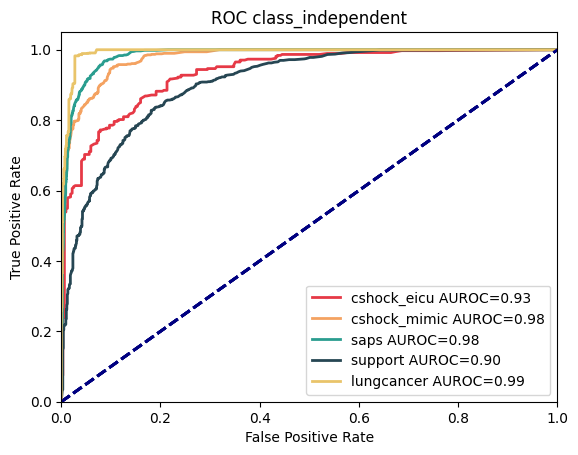

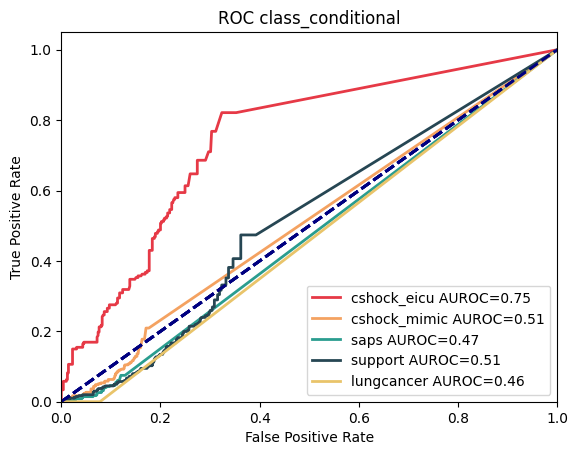

In [11]:
fixed_threshold = 0

datasets = ["cshock_eicu", "cshock_mimic", "saps", "support", "lungcancer"]

for noise_type in ["class_independent", "class_conditional"]:
    
    plt.figure()
    for i, dataset in enumerate(datasets):
        # Initialize lists to store the results and noise levels for DataFrame
        
        try:
            forward_df = load_metrics(model_type, noise_type, "forward", metric="disagreement_test", dataset = dataset, fixed_class=fixed_class, fixed_noise = fixed_noise)
            backward_df = load_metrics(model_type, noise_type, "backward", metric="disagreement_test", dataset = dataset, fixed_class=fixed_class, fixed_noise = fixed_noise)
        except:
            continue
        bright_colors = ['#E63946', '#F4A261', '#2A9D8F', '#264653', '#E9C46A']

        #for i,noise_level in enumerate([ 10, 20, 40]):
        
        noise_level = 20
        
        if (noise_level in forward_df["Noise Level (%)"].unique()) and (noise_level in backward_df["Noise Level (%)"].unique()):
        
            forward_sub_df = forward_df[(forward_df["Loss Function"]=="Ours") & (forward_df["Noise Level (%)"]==noise_level)]
            backward_sub_df = backward_df[(backward_df["Loss Function"]=="Ours") & (backward_df["Noise Level (%)"]==noise_level)]

            forward_values = forward_sub_df["Rate (%)"].values
            backward_values = backward_sub_df["Rate (%)"].values

            backward_values = np.clip(backward_values,0,100)/100
            forward_values = (forward_values> fixed_threshold).astype(int)

            fpr, tpr, _ = roc_curve(forward_values, backward_values)
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, color=bright_colors[i], lw=2, label=f'{dataset} AUROC=%0.2f' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC {noise_type}')
            plt.legend(loc="lower right")
    plt.show()

# Atypicality

In [ ]:
forward_df = load_metrics(model_type, noise_type, "forward", metric="disagreement_test", dataset = dataset, fixed_class=fixed_class, fixed_noise = fixed_noise)
